In [43]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix, classification_report
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from utils import calculate_metrics

# Original Dataset

In [44]:
# Load the data
df = pd.read_csv('../../data/processed/heart_se.csv')
# Split the data into features and target variable
X = df.drop(['target','index'], axis=1)
y = df['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# Define the objective function to be optimized
def objective(trial):
    # Suggest values for the hyperparameters
    n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    leaf_size = trial.suggest_int('leaf_size', 10, 50)
    p = trial.suggest_int('p', 1, 5)
    metric = trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan', 'chebyshev'])
    
    # Optionally, you can define metric_params if the metric requires additional parameters.
    # For simplicity, we'll set metric_params to None here.
    metric_params = None
    
    # Create a KNN classifier with the suggested hyperparameters
    knn = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        leaf_size=leaf_size,
        p=p,
        metric=metric,
        metric_params=metric_params
    )

    # Use cross-validation to evaluate the model
    score = cross_val_score(knn, X_train, y_train, n_jobs=-1, cv=3)
    accuracy = score.mean()

    return accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Train the final model with the best hyperparameters
knn = KNeighborsClassifier(**best_params)
knn.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = knn.predict(X_test)

# Evaluate the final model
accuracy = knn.score(X_test, y_test)
print(f"Test set accuracy: {accuracy:.2f}")

[I 2024-08-30 11:30:02,960] A new study created in memory with name: no-name-dbc8dd4d-59cf-4fe5-b42d-265b6bde8f4a


[I 2024-08-30 11:30:04,659] Trial 0 finished with value: 0.7024176954732511 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 20, 'p': 5, 'metric': 'chebyshev'}. Best is trial 0 with value: 0.7024176954732511.
[I 2024-08-30 11:30:05,065] Trial 1 finished with value: 0.8140432098765432 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 36, 'p': 5, 'metric': 'minkowski'}. Best is trial 1 with value: 0.8140432098765432.
[I 2024-08-30 11:30:05,453] Trial 2 finished with value: 0.8305555555555554 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 20, 'p': 5, 'metric': 'minkowski'}. Best is trial 2 with value: 0.8305555555555554.
[I 2024-08-30 11:30:05,829] Trial 3 finished with value: 0.8181584362139919 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'algorithm': 'brute', 'leaf_size': 20, 'p': 5, 'metric': 'minkowski'}. Best is trial 2 with value: 0.

Best hyperparameters: {'n_neighbors': 13, 'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 32, 'p': 3, 'metric': 'manhattan'}
Test set accuracy: 0.90


In [46]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_slice

# Plot the optimization history
opt_history = plot_optimization_history(study)
opt_history.show()


In [47]:
# Plot the hyperparameter importances
param_importance = plot_param_importances(study)
param_importance.show()

In [48]:

# Plot the parallel coordinate plot to visualize hyperparameter interactions
parallel_coordinate = plot_parallel_coordinate(study)
parallel_coordinate.show()

In [49]:

# Plot the slice plot for each hyperparameter
slice_plot = plot_slice(study)
slice_plot.show()

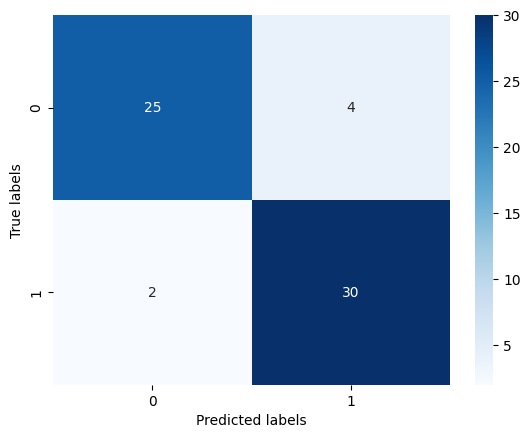

In [50]:
#test the model with the best hyperparameters
y_pred = knn.predict(X_test)

#plot the confusion matrix 
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()



In [51]:
# Generate a classification report
cls_report = classification_report(y_test, y_pred)
print(cls_report)

              precision    recall  f1-score   support

           0       0.93      0.86      0.89        29
           1       0.88      0.94      0.91        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



In [52]:
calculate_metrics(y_test, y_pred, 'knn')

Metrics saved to ./results/original/knn


# Rebalanced

In [53]:
# Load the data
df_train = pd.read_csv('../../data/processed/resampled/heart_resampled_train_se.csv')
df_test = pd.read_csv('../../data/processed/resampled/heart_resampled_test_se.csv')

# Split the data into features and target variable
X_train = df_train.drop(['target','index'], axis=1)
y_train = df_train['target']
X_test = df_test.drop(['target','index'], axis=1)
y_test = df_test['target']

In [54]:
# Define the objective function to be optimized
def objective(trial):
    # Suggest values for the hyperparameters
    n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    leaf_size = trial.suggest_int('leaf_size', 10, 50)
    p = trial.suggest_int('p', 1, 5)
    metric = trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan', 'chebyshev'])
    
    # Optionally, you can define metric_params if the metric requires additional parameters.
    # For simplicity, we'll set metric_params to None here.
    metric_params = None
    
    # Create a KNN classifier with the suggested hyperparameters
    knn = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        leaf_size=leaf_size,
        p=p,
        metric=metric,
        metric_params=metric_params
    )

    # Use cross-validation to evaluate the model
    score = cross_val_score(knn, X_train, y_train, n_jobs=-1, cv=3)
    accuracy = score.mean()

    return accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Train the final model with the best hyperparameters
knn = KNeighborsClassifier(**best_params)
knn.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = knn.predict(X_test)

# Evaluate the final model
accuracy = knn.score(X_test, y_test)
print(f"Test set accuracy: {accuracy:.2f}")

[I 2024-08-30 11:30:39,690] A new study created in memory with name: no-name-fbd7a513-4514-47c8-babd-814678e036a2
[I 2024-08-30 11:30:39,708] Trial 0 finished with value: 0.8475269940787182 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 16, 'p': 2, 'metric': 'minkowski'}. Best is trial 0 with value: 0.8475269940787182.
[I 2024-08-30 11:30:39,723] Trial 1 finished with value: 0.7748171368861024 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 10, 'p': 4, 'metric': 'euclidean'}. Best is trial 0 with value: 0.8475269940787182.
[I 2024-08-30 11:30:39,738] Trial 2 finished with value: 0.6565656565656566 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 34, 'p': 4, 'metric': 'chebyshev'}. Best is trial 0 with value: 0.8475269940787182.
[I 2024-08-30 11:30:39,754] Trial 3 finished with value: 0.8208376872169976 and parameters: {'n_neighbors': 9, 'weights': 'd

Best hyperparameters: {'n_neighbors': 15, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 50, 'p': 2, 'metric': 'minkowski'}
Test set accuracy: 0.84


In [55]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_slice

# Plot the optimization history
opt_history = plot_optimization_history(study)
opt_history.show()


In [56]:
# Plot the hyperparameter importances
param_importance = plot_param_importances(study)
param_importance.show()

In [57]:

# Plot the parallel coordinate plot to visualize hyperparameter interactions
parallel_coordinate = plot_parallel_coordinate(study)
parallel_coordinate.show()

In [58]:

# Plot the slice plot for each hyperparameter
slice_plot = plot_slice(study)
slice_plot.show()

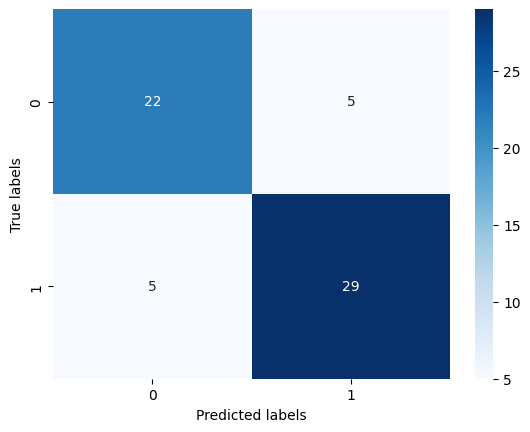

In [59]:
#test the model with the best hyperparameters
y_pred = knn.predict(X_test)

#plot the confusion matrix 
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()



In [60]:
# Generate a classification report
cls_report = classification_report(y_test, y_pred)
print(cls_report)

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        27
           1       0.85      0.85      0.85        34

    accuracy                           0.84        61
   macro avg       0.83      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



# Hand Model

In [85]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

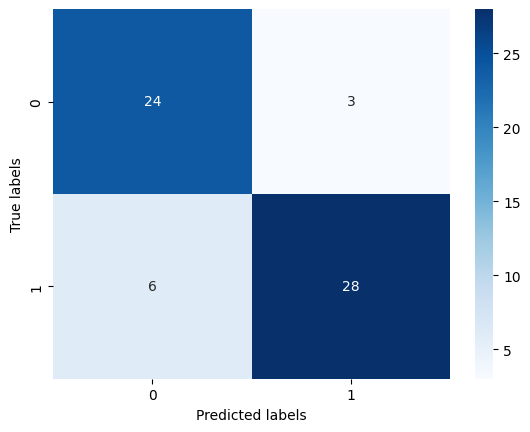

In [86]:
#plot the confusion matrix 
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [87]:
# Generate a classification report
cls_report = classification_report(y_test, y_pred)
print(cls_report)

              precision    recall  f1-score   support

           0       0.80      0.89      0.84        27
           1       0.90      0.82      0.86        34

    accuracy                           0.85        61
   macro avg       0.85      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61



In [88]:
calculate_metrics(y_test, y_pred, 'knn', rebalanced=True)

Metrics saved to ./results/rebalanced/knn
